# Flare predictor

In this prediction problem, we'll then ascribe each active region to one of two classes:

1. The positive class contains active regions that did produce a flare. 

2. The negative class contains active regions that did not produce a flare.

To create our CME predictor we need to gather our training dataset: 

1. Flare data from the GOES flare catalog at NOAA, which can be accessed with the `sunkit_instruments` library, a SunPy affiliated package for solar instrument-specific tools. This tells us if an active region produced a flare or not.

2. Active region data from the Solar Dynamics Observatory's `Helioseismic and Magnetic Imager instrument` (HMI), which can be accessed from the [JSOC database](http://jsoc.stanford.edu/) via a JSON API. This gives us the features characterizing each active region `SHARP` – Space-Weather HMI Active Region Patches [Bobra et al., 2014](http://link.springer.com/article/10.1007%2Fs11207-014-0529-3).

## 1: Gathering data for the positive class

First, we'll import some modules.

In [1]:
# General libraries
import numpy as np
import matplotlib.pylab as plt
import matplotlib.mlab as mlab
import pandas as pd
import scipy.stats
import requests
import urllib
import json
from datetime import datetime as dt_obj
from datetime import timedelta

# Machine learning libraries
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 50)

# Sunpy
try:
    import sunpy
    from sunpy.time import TimeRange
except ImportError:
    %pip install sunpy
    from sunpy.time import TimeRange

# Lime library
try:
    import lime
    import lime.lime_tabular
except ImportError:
    %pip install lime
    import lime
    import lime.lime_tabular
    
# Sunkit-instruments
try:
    import sunkit_instruments
except ImportError:
    %pip install sunkit_instruments
    import sunkit_instruments

Now we grab all the data from the GOES database

In [2]:
t_start = "2010-05-01" # Using solar cycle 24
t_end = "2011-05-01"  # Date for example, but using until 2024 for the full dataset (takes ~30min)

flag_for_fulldataset = False # If True, will save the full dataset to a file

In [3]:
# Grab all the data from the GOES database
time_range = TimeRange(t_start, t_end)
import sunkit_instruments.goes_xrs
listofflares = sunkit_instruments.goes_xrs.get_goes_event_list(time_range, 'M1')
print('Grabbed all the GOES data; there are', len(listofflares), 'events.')

Grabbed all the GOES data; there are 49 events.


In [4]:
# Only keep the events that have a NOAA active region
mistakes = 0
toremove = []
for i in range(len(listofflares)):
    
    if (listofflares[i]['noaa_active_region'] == 0):
        # remove the event from the list
        toremove.append(i)
        mistakes += 1
    
    if (listofflares[i]['noaa_active_region'] < 11000):
        # remove the event from the list
        toremove.append(i)
        mistakes += 1

print('There are', mistakes, 'mistakes so far.')
listofflares = [i for j, i in enumerate(listofflares) if j not in toremove]
print('There are', len(listofflares), 'events left.')

There are 5 mistakes so far.
There are 46 events left.


In [5]:
# Transform this into a pandas dataframe
df = pd.DataFrame(listofflares)

In [6]:
df

,event_date,start_time,peak_time,end_time,goes_class,goes_location,noaa_active_region
0,2010-05-05,2010-05-05 17:13:00.000,2010-05-05 17:19:00.000,2010-05-05 17:22:00.000,M1.2,"(37, 42)",11069
1,2010-06-12,2010-06-12 00:30:00.000,2010-06-12 00:57:00.000,2010-06-12 01:02:00.000,M2.0,"(43, 23)",11081
2,2010-06-13,2010-06-13 05:30:00.000,2010-06-13 05:39:00.000,2010-06-13 05:44:00.000,M1.0,"(84, -25)",11079
3,2010-08-07,2010-08-07 17:55:00.000,2010-08-07 18:24:00.000,2010-08-07 18:47:00.000,M1.0,"(-34, 11)",11093
4,2010-10-16,2010-10-16 19:07:00.000,2010-10-16 19:12:00.000,2010-10-16 19:15:00.000,M2.9,"(26, -20)",11112
5,2010-11-04,2010-11-04 23:30:00.000,2010-11-04 23:58:00.000,2010-11-05 00:12:00.000,M1.6,"(-76, -20)",11121
6,2010-11-05,2010-11-05 12:43:00.000,2010-11-05 13:29:00.000,2010-11-05 14:06:00.000,M1.0,"(0, 0)",11121
7,2010-11-06,2010-11-06 15:27:00.000,2010-11-06 15:36:00.000,2010-11-06 15:44:00.000,M5.4,"(-58, -19)",11121
8,2011-01-28,2011-01-28 00:44:00.000,2011-01-28 01:03:00.000,2011-01-28 01:10:00.000,M1.3,"(0, 0)",11149
9,2011-02-09,2011-02-09 01:23:00.000,2011-02-09 01:31:00.000,2011-02-09 01:35:00.000,M1.9,"(72, 17)",11153


In [7]:
answer = pd.read_csv(
    'http://jsoc.stanford.edu/doc/data/hmi/harpnum_to_noaa/all_harps_with_noaa_ars.txt', sep=' ')

In [8]:
timedelayvariable = 24

Now, we'll convert subtract `timedelayvariable` from the GOES Peak Time and re-format the datetime object into a string that JSOC can understand:

In [9]:
df['peak_time']

0     2010-05-05 17:19:00.000
1     2010-06-12 00:57:00.000
2     2010-06-13 05:39:00.000
3     2010-08-07 18:24:00.000
4     2010-10-16 19:12:00.000
5     2010-11-04 23:58:00.000
6     2010-11-05 13:29:00.000
7     2010-11-06 15:36:00.000
8     2011-01-28 01:03:00.000
9     2011-02-09 01:31:00.000
10    2011-02-13 17:38:00.000
11    2011-02-14 17:26:00.000
12    2011-02-15 01:56:00.000
13    2011-02-16 07:44:00.000
14    2011-02-16 14:25:00.000
15    2011-02-18 10:11:00.000
16    2011-02-18 10:26:00.000
17    2011-02-18 13:03:00.000
18    2011-02-18 14:08:00.000
19    2011-02-18 21:04:00.000
20    2011-02-24 07:35:00.000
21    2011-02-28 12:52:00.000
22    2011-03-07 05:13:00.000
23    2011-03-07 07:54:00.000
24    2011-03-07 08:07:00.000
25    2011-03-07 09:20:00.000
26    2011-03-07 14:30:00.000
27    2011-03-07 20:12:00.000
28    2011-03-07 21:50:00.000
29    2011-03-08 02:29:00.000
30    2011-03-08 03:58:00.000
31    2011-03-08 10:44:00.000
32    2011-03-08 18:28:00.000
33    2011

In [10]:
t_rec = [(df['peak_time'].iloc[i] - timedelta(hours=timedelayvariable)
          ).strftime('%Y.%m.%d_%H:%M_TAI') for i in range(df.shape[0])]

In [11]:
t_rec

['2010.05.04_17:19_TAI',
 '2010.06.11_00:57_TAI',
 '2010.06.12_05:39_TAI',
 '2010.08.06_18:24_TAI',
 '2010.10.15_19:12_TAI',
 '2010.11.03_23:58_TAI',
 '2010.11.04_13:29_TAI',
 '2010.11.05_15:36_TAI',
 '2011.01.27_01:03_TAI',
 '2011.02.08_01:31_TAI',
 '2011.02.12_17:38_TAI',
 '2011.02.13_17:26_TAI',
 '2011.02.14_01:56_TAI',
 '2011.02.15_07:44_TAI',
 '2011.02.15_14:25_TAI',
 '2011.02.17_10:11_TAI',
 '2011.02.17_10:26_TAI',
 '2011.02.17_13:03_TAI',
 '2011.02.17_14:08_TAI',
 '2011.02.17_21:04_TAI',
 '2011.02.23_07:35_TAI',
 '2011.02.27_12:52_TAI',
 '2011.03.06_05:13_TAI',
 '2011.03.06_07:54_TAI',
 '2011.03.06_08:07_TAI',
 '2011.03.06_09:20_TAI',
 '2011.03.06_14:30_TAI',
 '2011.03.06_20:12_TAI',
 '2011.03.06_21:50_TAI',
 '2011.03.07_02:29_TAI',
 '2011.03.07_03:58_TAI',
 '2011.03.07_10:44_TAI',
 '2011.03.07_18:28_TAI',
 '2011.03.07_20:16_TAI',
 '2011.03.08_11:07_TAI',
 '2011.03.08_14:02_TAI',
 '2011.03.08_23:23_TAI',
 '2011.03.11_04:43_TAI',
 '2011.03.13_19:52_TAI',
 '2011.03.14_00:22_TAI',


Now we can grab the SDO data from the JSOC database by executing the JSON queries. The SHARP parameters are calculated every 12 minutes during an AR lifetime. We are selecting data that satisfies several criteria: The data has to be [1] disambiguated with a version of the disambiguation module greater than 1.1, [2] taken while the orbital velocity of the spacecraft is less than 3500 m/s, [3] of a high quality, and [4] within 70 degrees of central meridian. If the data pass all these tests, they are put into one of two lists: one for the positive class (called CME_data) and one for the negative class (called no_CME_data).

In [12]:
def get_the_jsoc_data(event_count, t_rec):
    """
    Parameters
    ----------
    event_count: number of events 
                 int

    t_rec:       list of times, one associated with each event in event_count
                 list of strings in JSOC format ('%Y.%m.%d_%H:%M_TAI')

    """

    catalog_data = []
    classification = []

    for i in range(event_count):

        print("=====", i,"/",event_count-1,"=====")
        
        # Check if the active region number is not zero:
        if int(listofactiveregions[i]) == 0:
            print('skip: NOAA Active Region number is zero')
            continue
        
        # next match NOAA_ARS to HARPNUM
        idx = answer[answer['NOAA_ARS'].str.contains(
            str(int(listofactiveregions[i])))]

        # if there's no HARPNUM, quit
        if (idx.empty == True):
            print('skip: there are no matching HARPNUMs for',
                  str(int(listofactiveregions[i])))
            continue

        # construct jsoc_info queries and query jsoc database; we are querying for 25 keywords
        url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.sharp_720s["+str(
            idx.HARPNUM.values[0])+"]["+t_rec[i]+"][? (CODEVER7 !~ '1.1 ') and (abs(OBS_VR)< 3500) and (QUALITY<65536) ?]&op=rs_list&key=USFLUX,MEANGBT,MEANJZH,MEANPOT,SHRGT45,TOTUSJH,MEANGBH,MEANALP,MEANGAM,MEANGBZ,MEANJZD,TOTUSJZ,SAVNCPP,TOTPOT,MEANSHR,AREA_ACR,R_VALUE,ABSNJZH"
        response = requests.get(url)

        # if there's no response at this time, quit
        if response.status_code != 200:
            print('skip: cannot successfully get an http response')
            continue

        # read the JSON output
        data = response.json()

        # if there are no data at this time, quit
        if data['count'] == 0:
            print('skip: there are no data for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        # check to see if the active region is too close to the limb
        # we can compute the latitude of an active region in stonyhurst coordinates as follows:
        # latitude_stonyhurst = CRVAL1 - CRLN_OBS
        # for this we have to query the CEA series (but above we queried the other series as the CEA series does not have CODEVER5 in it)

        url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.sharp_cea_720s["+str(
            idx.HARPNUM.values[0])+"]["+t_rec[i]+"][? (abs(OBS_VR)< 3500) and (QUALITY<65536) ?]&op=rs_list&key=CRVAL1,CRLN_OBS"
        response = requests.get(url)

        # if there's no response at this time, quit
        if response.status_code != 200:
            print('skip: failed to find CEA JSOC data for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        # read the JSON output
        latitude_information = response.json()

        # if there are no data at this time, quit
        if latitude_information['count'] == 0:
            print('skip: there are no data for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        CRVAL1 = float(latitude_information['keywords'][0]['values'][0])
        CRLN_OBS = float(latitude_information['keywords'][1]['values'][0])
        if (np.absolute(CRVAL1 - CRLN_OBS) > 70.0):
            print('skip: latitude is out of range for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        if ('MISSING' in str(data['keywords'])):
            print('skip: there are some missing keywords for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        print('accept NOAA Active Region number', str(int(
            listofactiveregions[i])), 'and HARPNUM', idx.HARPNUM.values[0], 'at time', t_rec[i])

        individual_flare_data = []
        for j in range(18):
            individual_flare_data.append(
                float(data['keywords'][j]['values'][0]))

        catalog_data.append(list(individual_flare_data))

        single_class_instance = [idx.HARPNUM.values[0], str(
            int(listofactiveregions[i])), listofgoesclasses[i], t_rec[i]]
        classification.append(single_class_instance)

    return catalog_data, classification

Now we prepare the data to be fed into the function:

In [13]:
listofactiveregions = list(df['noaa_active_region'].values.flatten())
listofgoesclasses = list(df['goes_class'].values.flatten())

And call the function:

In [16]:
# get the data and save the data
if flag_for_fulldataset:
    Flare_data, Flare_class = get_the_jsoc_data(df.shape[0], t_rec)
    np.save('Flare_data_full.npy', Flare_data)
    np.save('Flare_class_full.npy', Flare_class)

else:
    Flare_data = np.load('flare_cycle24+/Flare_data_full.npy')
    Flare_class = np.load('flare_cycle24+/Flare_class_full.npy')
    


Here is the number of events associated with the positive class:

In [17]:
print("There are", len(Flare_data), "flare events in the positive class.")

There are 567 flare events in the positive class.


## 2: Gathering data for the negative class

In [18]:
# I will define non-flare events as regions with:
# -1, 0, + 1  AR region number (if same region, should be during quiet times: before the first flare and after the last flare)
# -36, +12 hours from the peak time of the flare event
n_negative_samples = len(Flare_data)*3

random_time = [-36, 12]
random_noaa = [-1,0,1]

flaringAR = list(df['noaa_active_region'].values.flatten())
flaringtime = list(df['peak_time'].values.flatten())
listofactiveregions = []
listofgoesclasses = []
t_rec = []

verbose = False
for nn in range(n_negative_samples):
    take1region = np.random.choice(flaringAR)
    takeflaringtime = flaringtime[flaringAR.index(take1region)]
    
    newtime = int(np.random.choice(random_time))
    newregion = -1 if newtime < 0 else 1
    active_region = + newregion + take1region
    time = takeflaringtime + timedelta(hours=newtime)
    
    if verbose:
        print('flaring region based on:', take1region, 'flaring time:', takeflaringtime)
        print('new region:', active_region, 'new time:', time)
    
    if active_region in flaringAR:

        # Show all the peak times for the active region:
        allflares_here = [flaringtime[i] for i in range(len(flaringAR)) if flaringAR[i] == active_region]
        
        # New time should be before 36 of the first peak of 12 after the last peak:
        if (time - timedelta(hours=36) < allflares_here[0]) or (time + timedelta(hours=12) > allflares_here[-1]):
            # print('skip: flaring time is too close to the peak times of the active region')
            continue

        
    listofactiveregions.append(active_region)
    listofgoesclasses.append('None')
    t_rec.append((time).strftime('%Y.%m.%d_%H:%M_TAI'))

n_negative_samples = len(listofactiveregions)

print("There are", len(listofactiveregions), "non-flare events in the negative class.")

There are 1123 non-flare events in the negative class.


Again, we compute times that are one day before the flare peak time and convert it into a string that JSOC can understand:

In [20]:
# get the data and save the data
if flag_for_fulldataset:
    nonFlare_data, nonFlare_class = get_the_jsoc_data(n_negative_samples, t_rec)

    np.save('nonFlare_data_full.npy', nonFlare_data)
    np.save('nonFlare_class_full.npy', nonFlare_class)

else:
    nonFlare_data = np.load('flare_cycle24+/nonFlare_data_full.npy')
    nonFlare_class = np.load('flare_cycle24+/nonFlare_class_full.npy')


Here is the number of events associated with the negative class:

In [21]:
print("There are", len(nonFlare_data), "noFlare events in the negative class.")

There are 800 noFlare events in the negative class.


In [22]:
# Ratio: negative class to positive class
ratio = len(nonFlare_data)/len(Flare_data)
print("Ratio of negative class to positive class:", ratio)


Ratio of negative class to positive class: 1.4109347442680775


## Load the full dataset

In [23]:
# Normalize the data
def normalize_together(positive_class, negative_class):
    positive_class = np.array(positive_class)
    negative_class = np.array(negative_class)
    both_classes = np.concatenate((positive_class, negative_class), axis=0)
    for j in range(both_classes.shape[1]):
        standard_deviation_of_this_feature = np.std(both_classes[:, j])
        median_of_this_feature = np.median(both_classes[:, j])
        for i in range(positive_class.shape[0]):
            positive_class[i, j] = (
                positive_class[i, j] - median_of_this_feature) / (standard_deviation_of_this_feature)
        for i in range(negative_class.shape[0]):
            negative_class[i, j] = (
                negative_class[i, j] - median_of_this_feature) / (standard_deviation_of_this_feature)
    return positive_class, negative_class


Flare_data, nonFlare_data = normalize_together(Flare_data, nonFlare_data)

In [24]:
# Combine all the data

N_features = Flare_data.shape[1]
Nfl = Flare_data.shape[0]
Nnofl = nonFlare_data.shape[0]
yfl = np.ones(Nfl)
ynofl = np.zeros(Nnofl)

xdata = np.concatenate((Flare_data, nonFlare_data), axis=0)
ydata = np.concatenate((yfl, ynofl), axis=0)
mdata = np.concatenate((Flare_class, nonFlare_class), axis=0)


## 3: Feature selection (filter methods)

An important step before starting to use any predictive method is to study the information present in the data. To do this, we are going to study the distribution of the characteristics of the active regions that produced a CME and those that did not. We will see the distribution of a feature for the active regions that produced a CME (green) and for the active regions that did not produce a CME (red). You can change the value of `i` in the code block below to see that some features are not at all useful since there is hardly any difference in the distributions for the positive and negative class. Therefore, we could discard those features from our sample before starting the modeling.

This exercise is commonly referred to as Feature filtering and is based on the statistical properties of the features, such as correlation, variance, etc. These methods are fast and scalable, but do not consider the interactions between features or the predictive power of the subset of features. Other feature selection methods will be discussed later.

In [27]:
sharps = ['Total unsigned flux', 'Mean gradient of total field',
          'Mean current helicity (Bz contribution)', 'Mean photospheric magnetic free energy',
          'Fraction of Area with Shear > 45 deg', 'Total unsigned current helicity',
          'Mean gradient of horizontal field', 'Mean characteristic twist parameter, alpha',
          'Mean angle of field from radial', 'Mean gradient of vertical field',
          'Mean vertical current density', 'Total unsigned vertical current',
          'Sum of the modulus of the net current per polarity',
          'Total photospheric magnetic free energy density', 'Mean shear angle',
          'Area of strong field pixels in the active region', 'Sum of flux near polarity inversion line',
          'Absolute value of the net current helicity']

sharp_mini = ['USFLUX', 'MEANGBT', 'MEANJZH', 'MEANPOT', 'SHRGT45', 'TOTUSJH', 'MEANGBH', 'MEANALP', 'MEANGAM', 'MEANGBZ', 'MEANJZD', 'TOTUSJZ', 'SAVNCPP', 'TOTPOT', 'MEANSHR', 'AREA_ACR', 'R_VALUE', 'ABSNJZH']


In [28]:
# # Random quantity is inserted to check the behaviour of the model
# q = 8
# sharps[q] = 'Random quantity'
# Flare_data[:,q] = np.random.normal(0, 1, Flare_data.shape[0])
# nonFlare_data[:,q] = np.random.normal(0, 1, nonFlare_data.shape[0])
# print('The quantity', sharps[q], 'is a fake quantity.')

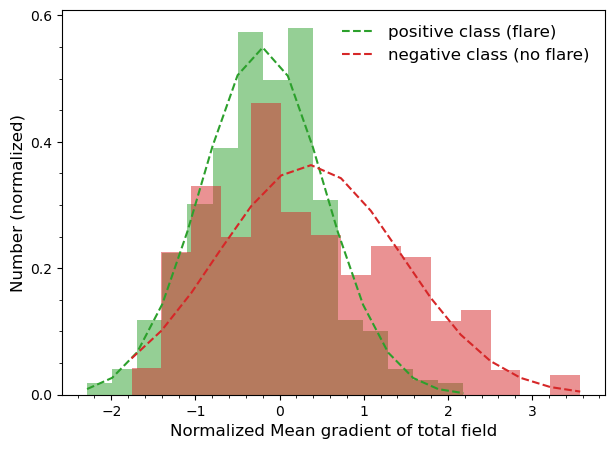

In [29]:
i = 1

plt.figure(figsize=(7, 5))

# For the positive class (green)
mu_fl = np.mean(Flare_data[:, i])
sigma_fl = np.std(Flare_data[:, i])
num_bins = 15
n_fl, bins_fl, patches_fl = plt.hist(Flare_data[:, i], num_bins, facecolor='C2', alpha=0.5,density=True)
y_fl = scipy.stats.norm.pdf(bins_fl, mu_fl, sigma_fl)
plt.plot(bins_fl, y_fl, 'C2--', label='positive class (flare)')

# For the negative class (red)
mu_nofl = np.mean(nonFlare_data[:, i])
sigma_nofl = np.std(nonFlare_data[:, i])
n_nofl, bins_nofl, patches_nofl = plt.hist(nonFlare_data[:, i], num_bins, facecolor='C3', alpha=0.5,density=True)
y_nofl = scipy.stats.norm.pdf(bins_nofl, mu_nofl, sigma_nofl)
plt.plot(bins_nofl, y_nofl, 'C3--', label='negative class (no flare)')

plt.xlabel('Normalized '+sharps[i], fontsize=12)
plt.ylabel('Number (normalized)', fontsize=12)
plt.minorticks_on()
plt.locator_params(axis='y', nbins=6)
legend = plt.legend(loc='upper right', fontsize=12, framealpha=0.0, title='')
# plt.savefig('figures/feature_'+str(i)+'.png', dpi=300, bbox_inches='tight')


Now we will compute the Univariate F-score for feature selection. It is a very simple method: the F-score measures the distance between the two distributions for a given feature (inter-class distance), divided by the sum of the variances for this feature (intra-class distance). We can use the `sklearn.feature_selection` module to do this:

Text(0.5, 1.0, 'Normalized Fisher Score for each feature')

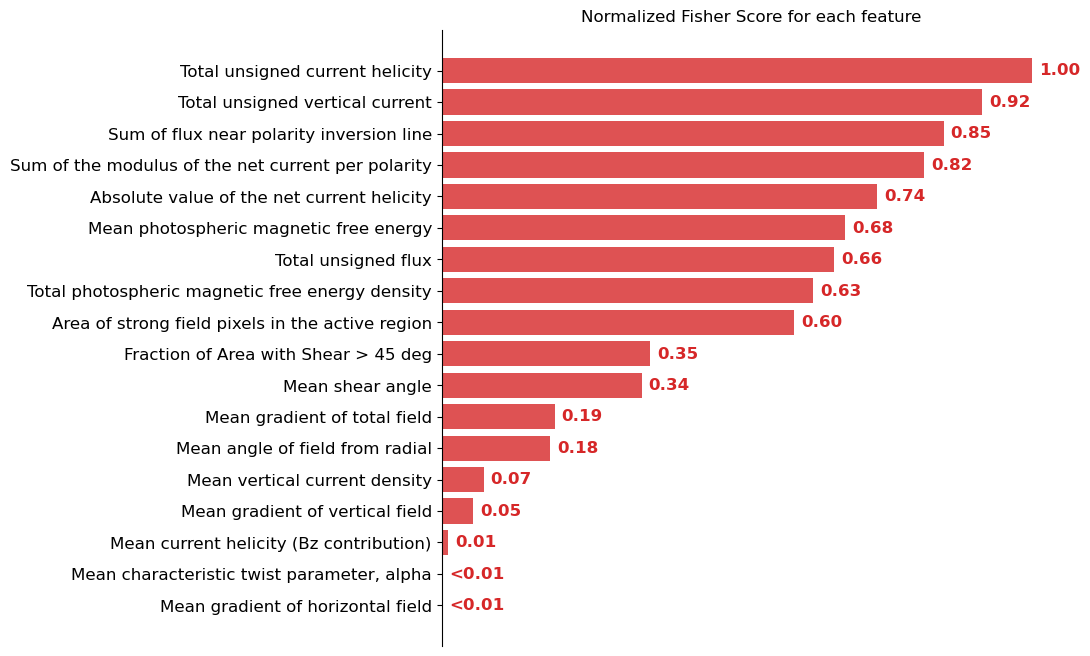

In [30]:
# import the feature selection method
from sklearn.feature_selection import SelectKBest, f_classif

# k is the number of features
selector = SelectKBest(f_classif, k=N_features)
selector.fit(xdata, ydata)
scores = selector.scores_


import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize=(8, 8))
order = np.argsort(selector.scores_)
orderedsharps = [sharps[i] for i in order]
orderedscores = [selector.scores_[i]/np.max(selector.scores_) for i in order]
y_pos2 = np.arange(N_features)
bars = plt.barh(y_pos2, orderedscores, color='C3', alpha=0.8, height=0.8)
plt.yticks(y_pos2, orderedsharps, fontsize=12)
plt.xlabel('Normalized Fisher Score', fontsize=12)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.spines[['right', 'top', 'bottom']].set_visible(False) 
ax.xaxis.set_visible(False)

def custom_fmt(x):
    return '<0.01' if x < 0.01 else '%.2f' % x

ax.bar_label(bars, padding=+5, color='C3', 
             fontsize=12, label_type='edge', fmt=custom_fmt,
             fontweight='bold')
# Add title:
plt.title('Normalized Fisher Score for each feature')
# plt.savefig('figures/Fisher_score.png', dpi=300, bbox_inches='tight')

In [31]:
# # Use only the first 2 features:
# Flare_data = Flare_data[:, :2]
# nonFlare_data = nonFlare_data[:, :2]
# xdata = np.concatenate((Flare_data, nonFlare_data), axis=0)
# ydata = np.concatenate((yfl, ynofl), axis=0)
# mdata = np.concatenate((Flare_class, nonFlare_class), axis=0)
# N_features = Flare_data.shape[1]


## Step 4: The support vector machine

Now we initialize the support vector machine on the data. The SVM uses non-linear decision functions to map the feature space into a higher-dimensional space, where the positive and negative examples can be separated linearly by a hyperplane. <br>

This is incredibly non-intuitive. But we can think of a simpler example. Suppose we had two classes: CME-producing and non-CME producing active regions. And suppose we had two features: the total flux in these regions, and the total area of these regions. We could construct a two-dimentional feature space, where we plot the flux against the area of each active region. Positive examples could be indicated by an X and negatives ones by an O. In theory, if our data behaved well, we could draw a line between these classess. <br>

Since we have 18 features, the SVM constructs an 18-dimensional feature space. In this feature space, the decision boundary separating the positive and negative examples may be non-linear. As such, the algorithm then enlarges this 18-dimensional feature space (using the function indicated by the `kernel` parameter in the [`svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) function) into a higher-dimensional feature space wherein it is possible to linearly separate the positive and negatives classes. There are lots of people trying to work on how to [visualize these multi-dimensional feature spaces](https://github.com/tmadl/highdimensional-decision-boundary-plot), which is an active area of research.

In [32]:
C = 1e0
gamma = 1e0
clf = svm.SVC(C=C, gamma=gamma, kernel='rbf', class_weight='balanced',
              cache_size=500, max_iter=-1, shrinking=True, tol=1e-8, probability=True)


## Step 5: Stratified k-folds cross-validation

There are lots of different ways to evaluate the performance of a classifier. We're going to choose a metric called the True Skill Score, or the TSS, which we can calculate from four quantities: true positives, true negatives, false positives, and false negatives. We prefer the TSS to all the other metrics as it is insensitive to the class imbalance ratio and thus best for comparison to other studies. The TSS is symmetrically distributed about 0: i.e., it goes from [-1, 1] where 0 represents no skill and a negative value represents a perverse prediction.

In [33]:
def confusion_table(pred, labels):
    """
    computes the number of TP, TN, FP, FN events given the arrays with predictions and true labels
    and returns the true skill score

    Args:
    pred: np array with predictions (1 for flare, 0 for nonflare)
    labels: np array with true labels (1 for flare, 0 for nonflare)

    Returns: true negative, false positive, true positive, false negative
    """
    Nobs = len(pred)
    TN = 0.
    TP = 0.
    FP = 0.
    FN = 0.
    for i in range(Nobs):
        if (pred[i] == 0 and labels[i] == 0):
            TN += 1
        elif (pred[i] == 1 and labels[i] == 0):
            FP += 1
        elif (pred[i] == 1 and labels[i] == 1):
            TP += 1
        elif (pred[i] == 0 and labels[i] == 1):
            FN += 1
        else:
            print("Error! Observation could not be classified.")
    return TN, FP, TP, FN

Now we run the SVM on our data and cross-validate our results. In our case, the positive sample size is quite small (both objectively and compared to the negative sample size). Therefore, we use a stratified k-folds cross-validation method, which makes k partitions of the data set and uses k-1 folds for training the SVM and 1 fold for testing the trained SVM. The stratification preserves the ratio of positive to negative examples per fold. Then we can permute over the partitions such that each partition eventually makes its way into the testing set. For each individual testing set, we can calculate a skill score. Then we can average the skill scores over the total number of testing sets. 

To compute the TSS, we must first select a value of k. k can be arbitrarily defined and take any value between 2 and `number_of_examples`, so we can explore this parameter space. As k approaches `number_of_examples`, the k-fold method reduces to the Leave One Out method, in which only one example is in the testing set and all other examples are in the training set. The literature suggests this method is not the best, so we can stray away from high values of k. Many studies (e.g. [Kohavi, 1995](http://web.cs.iastate.edu/~jtian/cs573/Papers/Kohavi-IJCAI-95.pdf)) recommend the stratified 10-fold cross-validation to reduce variance and bias. Here, we test their recommendation by computing the TSS using 30 k values, ranging from 2 to 32. 

Now we can plot the mean TSS per k, using the standard deviation as the error in the TSS. We see that for high values of k, the standard deviation in the TSS can be greater than the mean. These points are indicated in blue.

As such, we confirm that high k-values result in a high variance. We find it reasonable to use the stratified 10-fold cross-validation method to compute the TSS and will follow this recommendation. Therefore we report this score as our final result:

In [34]:
C = 1e0
gamma = 1e0
clf = svm.SVC(C=C, gamma=gamma, kernel='rbf', class_weight='balanced',
              cache_size=500, max_iter=-1, shrinking=True, tol=1e-8, probability=True)


k = 4 # 25% of the data is used for testing
skf = StratifiedKFold(n_splits=k, shuffle=True)
from sklearn.model_selection import RepeatedStratifiedKFold
# skf = RepeatedStratifiedKFold(n_splits=k, n_repeats=10)
these_TSS_for_this_k = []
confusion_matrix_k = []
for train_index, test_index in skf.split(xdata, ydata):
    # xtrain are the examples in the training set
    xtrain = xdata[train_index]
    # ytrain are the labels in the training set
    ytrain = ydata[train_index]
    # xtest are the examples in the testing set
    xtest = xdata[test_index]
    # ytest are the labels in the testing set
    ytest = ydata[test_index]    
    # metadata useful for interpreting with LIME
    mtrain = mdata[train_index]
    # metadata useful for interpreting with LIME
    mtest = mdata[test_index]
    clf.fit(xtrain, ytrain)
    TN, FP, TP, FN = confusion_table(clf.predict(xtest), ytest)
    if (((TP+FN) == 0.0) or (FP+TN) == 0.0):
        these_TSS_for_this_k.append(np.nan)
        continue
    else:
        these_TSS_for_this_k.append(TP/(TP+FN) - FP/(FP+TN))
        confusion_matrix_k.append([TN, FP, TP, FN])
    # break
confusion_matrix_ = np.mean(confusion_matrix_k, axis=0)
TSS_k = np.array(these_TSS_for_this_k)

print(confusion_matrix_)

[181.25  18.75 128.5   13.25]


In [35]:
TN, FP, TP, FN = confusion_matrix_
confusion_matrix = np.array([TP, FN, FP, TN]).reshape(2, 2)
print(TP/(TP+FN) - FP/(FP+TN))

0.8127755731922398


<Figure size 800x800 with 0 Axes>

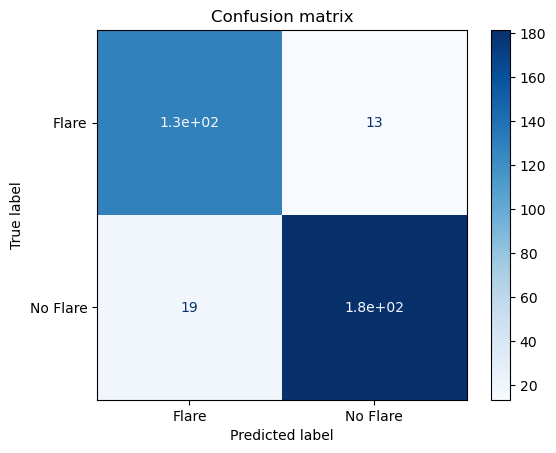

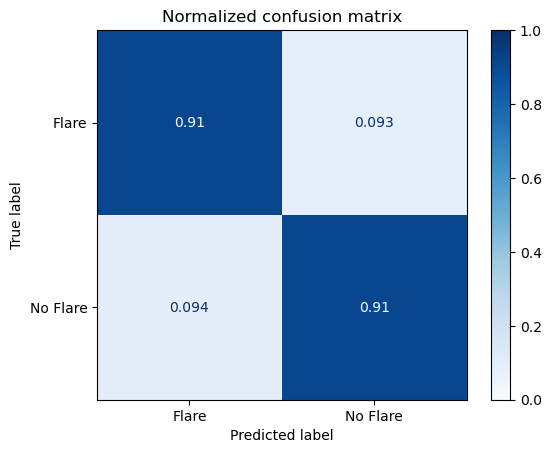

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(8, 8))
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['Flare','No Flare'])
display.plot(cmap='Blues')
plt.title('Confusion matrix')

# Now normalize the confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix= (confusion_matrix.T / np.sum(confusion_matrix,axis=1)).T, display_labels=['Flare','No Flare'])
display.plot(cmap='Blues')
plt.title('Normalized confusion matrix')
for im in plt.gca().get_images():                   # set clim manually within the image
    im.set_clim(vmin=0,vmax=1) 
plt.savefig('figures/confusion_matrix.png', dpi=300, bbox_inches='tight')

# Hyperparameter tuning:


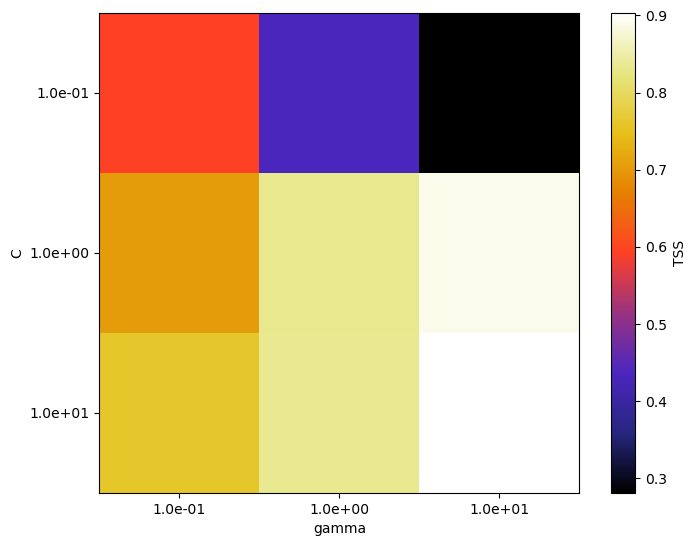

In [37]:
# TSS
TSS_tun_list = []

# Suffling xdata and ydata:
idx = np.arange(len(xdata))
np.random.shuffle(idx)
xdata = xdata[idx]
ydata = ydata[idx]


# Train the model
param_grid = {'C': 10**np.arange(-1, 2, 1.0),
              'gamma': 10**np.arange(-1, 2, 1.0)}

# skf = StratifiedKFold(n_splits=4, shuffle=True)
skf = RepeatedStratifiedKFold(n_splits=4, n_repeats=5)
for CC in param_grid['C']:
    for GG in param_grid['gamma']:

        clf = svm.SVC(C=CC, gamma=GG, kernel='rbf', class_weight='balanced',
                    cache_size=500, max_iter=-1, shrinking=True, tol=1e-8, probability=True)
        
        these_TSS_for_this_k = []
        for train_index, test_index in skf.split(xdata, ydata):
            xtrainq = xdata[train_index]
            ytrainq = ydata[train_index]
            xtestq = xdata[test_index]
            ytestq = ydata[test_index]
            

            clf.fit(xtrainq, ytrainq)
            
            TN, FP, TP, FN = confusion_table(clf.predict(xtestq), ytestq)
            if (((TP+FN) == 0.0) or (FP+TN) == 0.0) or (TP == 0.0) or (FP == 0.0):
                these_TSS_for_this_k.append(np.nan)
                continue
            else:
                these_TSS_for_this_k.append(TP/(TP+FN) - FP/(FP+TN))
                # print(TP,FP,FN)
                # these_TSS_for_this_k.append(TP/(TP+FP))
        TSS_k = np.array(these_TSS_for_this_k)
        TSS_tun_list.append(np.mean(TSS_k))

TSS_tuned = np.array(TSS_tun_list).reshape(len(param_grid['C']), len(param_grid['gamma']))
# replace nans by 0.0
TSS_tuned = np.nan_to_num(TSS_tuned)

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
plt.imshow(TSS_tuned, interpolation='nearest', cmap='CMRmap',vmin=None, vmax=None)
plt.xlabel('gamma')
plt.ylabel('C')
plt.xticks(np.arange(len(param_grid['gamma'])), ['%.1e' % i for i in param_grid['gamma']])
plt.yticks(np.arange(len(param_grid['C'])), ['%.1e' % i for i in param_grid['C']])
cb = plt.colorbar()
cb.set_label('TSS')

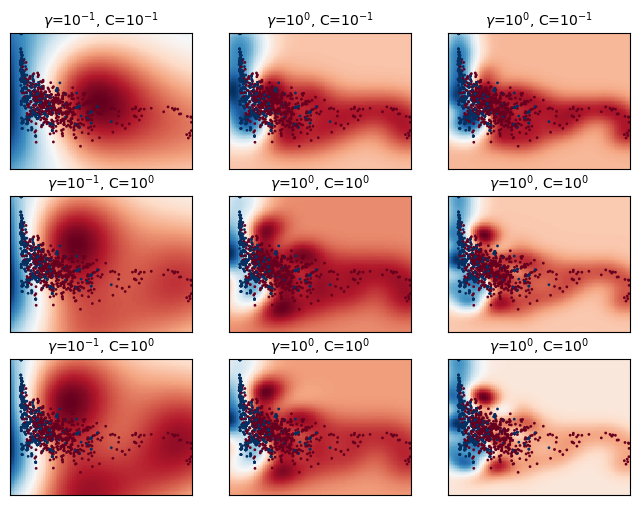

In [47]:
C_2d_range = [1e-1, 1, 2]
gamma_2d_range = [1e-1, 1, 2]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf_ = svm.SVC(C=C, gamma=gamma, kernel='rbf', class_weight='balanced',
                cache_size=500, max_iter=-1, shrinking=True, tol=1e-8, probability=True)
        clf_.fit(xdata[:, :2], ydata)
        classifiers.append((C, gamma, clf_))
        

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(xdata[:, 0].min()*1.5, xdata[:, 0].max(), 100), np.linspace(xdata[:, 1].min()*1.5, xdata[:, 1].max(), 100))
for k, (C, gamma, clf_) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf_.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title(r"$\gamma$=$10^{%d}$, C=$10^{%d}$" % (np.log10(gamma), np.log10(C)), size="medium")

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(xdata[:, 0], xdata[:, 1], c=ydata, cmap=plt.cm.RdBu_r, s=1)
    plt.xticks(())
    plt.yticks(())
    plt.axis("tight")



# Step 6: Feature selection (wrapper methods)

In [39]:
C = 1e0
gamma = 1e0
clf_q = svm.SVC(C=C, gamma=gamma, kernel='rbf', class_weight='balanced',
              cache_size=500, max_iter=-1, shrinking=True, tol=1e-8, probability=True)


# Sequential feature selection: adding features one by one

TSS_for_this_combination = []
# features_to_use is the index saved in best_combination and the index of the feature we are testing
for feature_to_test in range(N_features):

    # skf = StratifiedKFold(n_splits=4, shuffle=True)
    skf = RepeatedStratifiedKFold(n_splits=4, n_repeats=2)
    these_TSS_for_this_k = []
    for train_index, test_index in skf.split(xdata, ydata):
        xtrain = xdata[train_index][:, feature_to_test:feature_to_test+1]
        ytrain = ydata[train_index]
        xtest = xdata[test_index][:, feature_to_test:feature_to_test+1]
        mtest = mdata[test_index]
        ytest = ydata[test_index]
        clf_q.fit(xtrain, ytrain)
        TN, FP, TP, FN = confusion_table(clf_q.predict(xtest), ytest)
        these_TSS_for_this_k.append(TP/(TP+FN) - FP/(FP+TN))
    TSS = np.mean(these_TSS_for_this_k)
    
    TSS_for_this_combination.append(TSS)

    

Text(0.5, 1.0, 'Normalized Fisher Score, ordered by single TSS score')

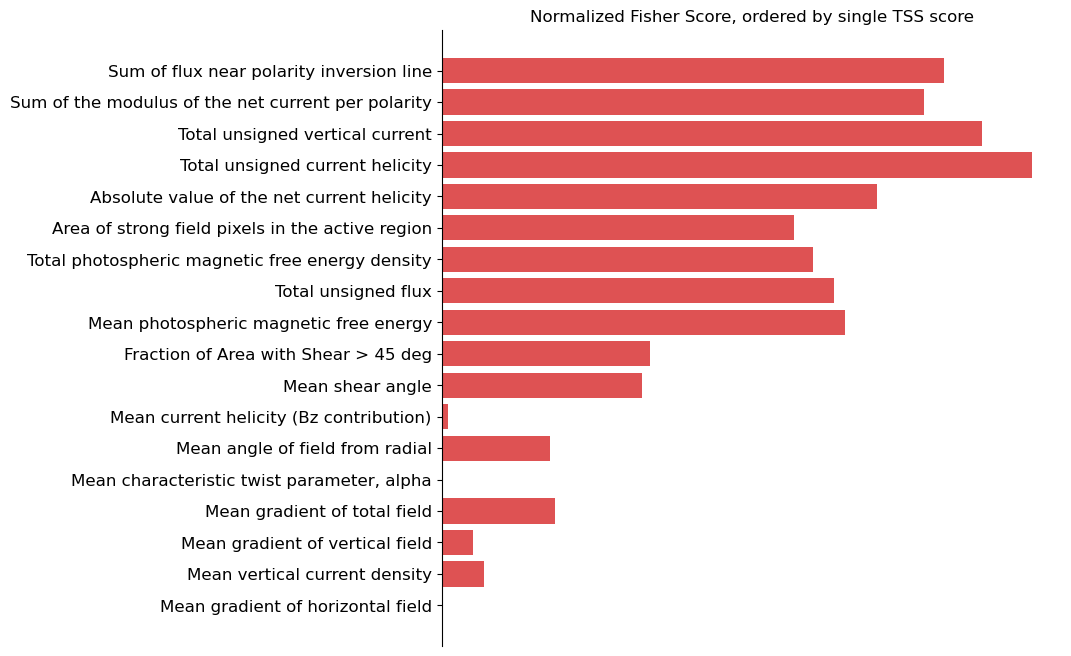

In [40]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize=(8, 8))

norder = np.argsort(TSS_for_this_combination)
norderedsharps = [sharps[i] for i in norder]
nscores = [selector.scores_[i] for i in norder]
y_pos2 = np.arange(18)
bars = plt.barh(y_pos2, nscores/np.max(scores), color='C3', alpha=0.8, height=0.8)
plt.yticks(y_pos2, norderedsharps, fontsize=12)
plt.xlabel('Normalized Fisher Score', fontsize=12)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.spines[['right', 'top', 'bottom']].set_visible(False) 
ax.xaxis.set_visible(False)

plt.title('Normalized Fisher Score, ordered by single TSS score')

In [41]:

# Sequential feature selection: adding features one by one

total_features = N_features

best_combination = []
TSS_for_best_combination = []
for combination in range(1, total_features+1):
    TSS_for_this_combination = []
    # features_to_use is the index saved in best_combination and the index of the feature we are testing
    for feature_to_test in range(total_features):
        if feature_to_test in best_combination:
            TSS_for_this_combination.append(0.0)
            continue
        features_to_use = best_combination.copy()
        features_to_use.append(feature_to_test)

        # skf = StratifiedKFold(n_splits=4, shuffle=True)
        skf = RepeatedStratifiedKFold(n_splits=4, n_repeats=2)
        these_TSS_for_this_k = []
        for train_index, test_index in skf.split(xdata, ydata):
            xtrain = xdata[train_index][:, features_to_use]
            ytrain = ydata[train_index]
            xtest = xdata[test_index][:, features_to_use]        
            # mtest = mdata[test_index]
            ytest = ydata[test_index]
            clf.fit(xtrain, ytrain)
            TN, FP, TP, FN = confusion_table(clf.predict(xtest), ytest)
            these_TSS_for_this_k.append(TP/(TP+FN) - FP/(FP+TN))
        TSS = np.mean(these_TSS_for_this_k)
        
        TSS_for_this_combination.append(TSS)
    # print('All TSS for this combination:', TSS_for_this_combination)
    
    best_combination.append(np.argmax(TSS_for_this_combination))
    TSS_for_best_combination.append(np.max(TSS_for_this_combination))
    print("The best combination so far is", best_combination, "with a TSS of", "{:.2f}".format(np.max(TSS_for_this_combination)), 
          "where addition had a score of", "{:.2f}".format(selector.scores_[np.argmax(TSS_for_this_combination)]/np.max(selector.scores_)))

    # break
    
    

The best combination so far is [16] with a TSS of 0.61 where addition had a score of 0.85
The best combination so far is [16, 1] with a TSS of 0.71 where addition had a score of 0.19
The best combination so far is [16, 1, 3] with a TSS of 0.81 where addition had a score of 0.68
The best combination so far is [16, 1, 3, 12] with a TSS of 0.83 where addition had a score of 0.82
The best combination so far is [16, 1, 3, 12, 0] with a TSS of 0.87 where addition had a score of 0.66
The best combination so far is [16, 1, 3, 12, 0, 5] with a TSS of 0.89 where addition had a score of 1.00
The best combination so far is [16, 1, 3, 12, 0, 5, 17] with a TSS of 0.90 where addition had a score of 0.74
The best combination so far is [16, 1, 3, 12, 0, 5, 17, 13] with a TSS of 0.90 where addition had a score of 0.63
The best combination so far is [16, 1, 3, 12, 0, 5, 17, 13, 2] with a TSS of 0.90 where addition had a score of 0.01
The best combination so far is [16, 1, 3, 12, 0, 5, 17, 13, 2, 7] with 

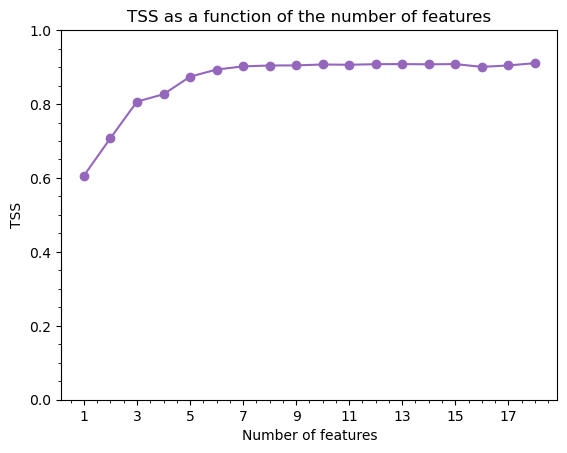

In [42]:
# An important trend we can already see is that as we start adding too many features, the TSS starts to decrease.
plt.plot(np.arange(1, total_features+1), TSS_for_best_combination, 'o-', color='C4')
plt.xlabel('Number of features')
plt.ylabel('TSS')
plt.title('TSS as a function of the number of features')
plt.xticks(np.arange(1, total_features+1))
plt.ylim(ymax=1.0, ymin=0)
plt.locator_params(axis='x', nbins=9)
plt.minorticks_on()
plt.savefig('figures/TSS_vs_number_of_features.png', dpi=300, bbox_inches='tight')

## Model-Agnostic "local" Explanations (Shapley values)

Machine-learning is a powerful technique that can help us predict certain events. However, our goal is not only to predict them, but also to quantitatively understand which signatures indicate the imminent triggering of the event. To do this, we can use different tools (like the SHAP library) to explain the model's predictions. SHAP values represent the contribution of each feature to the prediction as an additive feature attribution, so one can understand the importance of each feature in the prediction.

In [48]:
# Quick training
# import random split
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, test_size=0.25, random_state=42)


clf.fit(xtrain, ytrain)
TN, FP, TP, FN = confusion_table(clf.predict(xtest), ytest)
confusion_matrix_ = np.mean(confusion_matrix_k, axis=0)

print(confusion_matrix_)

[181.25  18.75 128.5   13.25]


In [49]:
import shap
shap.initjs()

explainer = shap.KernelExplainer(clf.predict_proba, shap.kmeans(xdata, 200))


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [50]:
i = np.random.randint(0, xtest.shape[0])
shap_values = explainer.shap_values(xtest[i, :])
shap.force_plot(explainer.expected_value[0], shap_values[:, 0], xtest[i, :], feature_names=sharps)

As we can see, the force plot shows the contribution of each feature to the prediction. The color represents the value of the feature (red for high values, blue for low values). The features are ordered by importance, with the most important features at the top. The larger the arrow, the more the feature contributes to the prediction. The base value is the average prediction over the training set. The output value is the prediction of the model.

In [53]:
# Find the event in the metadata:
index_event = np.where(np.all(xdata == xtest[i, :], axis=1))[0][0]
print("The AR number", mdata[index_event][1], "had a flare of class", mdata[index_event][2], "at", mdata[index_event][3])

The AR number 12445 had a flare of class M1.9 at 2015.11.03_03:26_TAI
